# Oracle-Reto 2: Análisis de sentimiento

*NUWE EVA*, la cadena de restauración fast food y healthy, sigue creciendo y queremos dar un paso más para mejorar y ofrecer el mejor servicio posible a nuestros clientes.

Queremos evolucionar y ofrecer nuevas capacidades a nuestro robot y talentoso camarero, *EVA*, añadiendo la función de poder detectar, a través de frases y palabras utilizadas por los comensales, el grado de satisfacción de los platos probados y así ver qué platos y productos han gustado más o menos a los clientes.

Nuestro robot ya sabe detectar lo que pedirán los comensales según los productos elegidos. Ahora queremos saber cuál es el feedback de cada cliente para detectar si le ha gustado o no el plato servido.

> Objetivo
Crea un modelo predictivo de **clasificación** para poder **ordenar y o catalogar las reseñas**. Primero entrena tu modelo con las reseñas de entrenamiento. Una vez tengas el modelo que maximice la puntuación F1 (macro.), utiliza las reseñas de prueba como entrada para tu modelo.

In [1]:
from numpy import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
from textblob import TextBlob
import nltk as nlp
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

2023-04-19 11:44:59.533640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('../Data/train.csv',index_col = [0])
test = pd.read_csv('../Data/test.csv',index_col = [0])

In [3]:
train.head()

,text,label,label_text
train_idx,,,
0,i really do recommend this to anyone in need o...,1,positive
1,very good every day camera fits nicely in the ...,1,positive
2,"but , dollar for dollar , this dvd player is p...",1,positive
3,i got this phone yesterday and didn ' t find a...,1,positive
4,1 ) price gb of storage,1,positive


In [4]:
test.head()

,text
test_idx,
0,fm receiver it has none
1,"the picture quality surprised me , when i firs..."
2,great video clip quality for a digital camera ...
3,creative did well on its rechargeable battery ...
4,i highly recommend this camera to anyone looki...


In [5]:
''' shape '''
print(f'shape de los datos train {train.shape}')
print(f'shape de los datos test {test.shape}')

shape de los datos train (3016, 3)
shape de los datos test (754, 1)


In [6]:
train.label.value_counts()

1    1926
0    1090
Name: label, dtype: int64

In [7]:
''' valores duplicados '''
train.duplicated().sum()

4

In [8]:
train = train.drop_duplicates()
train.drop(['label_text'],axis = 1,inplace = True)

# Preprocessing

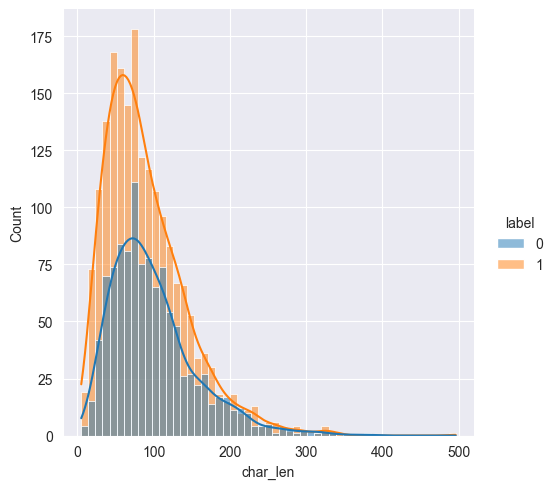

In [9]:
train["char_len"] = train["text"].apply(lambda x: len(x))

sns.displot(train, x="char_len", kde=True, hue="label")
plt.show()

# no existe diferencia

In [10]:
train.drop(columns="char_len", inplace=True)

In [11]:
train.text

train_idx
0       i really do recommend this to anyone in need o...
1       very good every day camera fits nicely in the ...
2       but , dollar for dollar , this dvd player is p...
3       i got this phone yesterday and didn ' t find a...
4                                 1 ) price gb of storage
                              ...                        
3011    as for itunes , i don ' t find it to be as goo...
3012    i have not played with all the features yet , ...
3013    applications it has lots of applications and t...
3014                                    battery non issue
3015    the fm tuner , the 5g of storage , and the rem...
Name: text, Length: 3012, dtype: object

In [12]:
train['text'] = train['text'].apply(lambda x: x.replace(" ' ","'"))
train['text'] = train['text'].apply(lambda x: x.replace(" n't ","n't "))

test['text'] = test['text'].apply(lambda x: x.replace(" ' ","'"))
test['text'] = test['text'].apply(lambda x: x.replace(" n't ","n't "))

In [13]:
train['text'] = train['text'].apply(lambda x: x.replace("s'","'s "))

test['text'] = test['text'].apply(lambda x: x.replace("s'","'s "))

In [14]:
train['text']

train_idx
0       i really do recommend this to anyone in need o...
1       very good every day camera fits nicely in the ...
2       but , dollar for dollar , this dvd player is p...
3       i got this phone yesterday and didn't find any...
4                                 1 ) price gb of storage
                              ...                        
3011    as for itunes , i don't find it to be as good ...
3012    i have not played with all the features yet , ...
3013    applications it has lots of applications and t...
3014                                    battery non issue
3015    the fm tuner , the 5g of storage , and the rem...
Name: text, Length: 3012, dtype: object

In [15]:
# eliminamos las contracciones del tipo don't -> do not
train["clean_text"] = train["text"].apply(lambda x: contractions.fix(x))

test["clean_text"] = test["text"].apply(lambda x: contractions.fix(x))

In [16]:
train["clean_text"]

train_idx
0       i really do recommend this to anyone in need o...
1       very good every day camera fits nicely in the ...
2       but , dollar for dollar , this dvd player is p...
3       i got this phone yesterday and did not find an...
4                                 1 ) price gb of storage
                              ...                        
3011    as for itunes , i do not find it to be as good...
3012    i have not played with all the features yet , ...
3013    applications it has lots of applications and t...
3014                                    battery non issue
3015    the fm tuner , the 5g of storage , and the rem...
Name: clean_text, Length: 3012, dtype: object

In [17]:
def tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte t0do el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

In [18]:
train['token'] = train['clean_text'].apply(lambda x: tokenizar(x))
test['token'] = test['clean_text'].apply(lambda x: tokenizar(x))
train[['clean_text', 'token']]

,clean_text,token
train_idx,,
0,i really do recommend this to anyone in need o...,"[really, do, recommend, this, to, anyone, in, ..."
1,very good every day camera fits nicely in the ...,"[very, good, every, day, camera, fits, nicely,..."
2,"but , dollar for dollar , this dvd player is p...","[but, dollar, for, dollar, this, dvd, player, ..."
3,i got this phone yesterday and did not find an...,"[got, this, phone, yesterday, and, did, not, f..."
4,1 ) price gb of storage,"[price, gb, of, storage]"
...,...,...
3011,"as for itunes , i do not find it to be as good...","[as, for, itunes, do, not, find, it, to, be, a..."
3012,"i have not played with all the features yet , ...","[have, not, played, with, all, the, features, ..."
3013,applications it has lots of applications and t...,"[applications, it, has, lots, of, applications..."


In [19]:
Xtrain = train.explode('token')
Xtest = test.explode('token')
Xtrain.head()

,text,label,clean_text,token
train_idx,,,,
0,i really do recommend this to anyone in need o...,1,i really do recommend this to anyone in need o...,really
0,i really do recommend this to anyone in need o...,1,i really do recommend this to anyone in need o...,do
0,i really do recommend this to anyone in need o...,1,i really do recommend this to anyone in need o...,recommend
0,i really do recommend this to anyone in need o...,1,i really do recommend this to anyone in need o...,this
0,i really do recommend this to anyone in need o...,1,i really do recommend this to anyone in need o...,to


In [20]:
# Mean length and std of the reviews
Xtrain.groupby(['train_idx'])['token'].count().describe()

count    3012.000000
mean       16.293161
std         9.516930
min         1.000000
25%         9.000000
50%        14.000000
75%        21.000000
max        72.000000
Name: token, dtype: float64

In [21]:
# most used words in the reviews
Xtrain['token'].value_counts(ascending=False)

the          3211
and          1517
is           1369
it           1337
to           1331
             ... 
foreign         1
hassles         1
substance       1
earned          1
handful         1
Name: token, Length: 4528, dtype: int64

Podemos observar como las palabras más utilizadas en las *reviews* son en su mayoría pronombres o conjunciones, que no aportan información alguna.

Utilizaremos por tanto *stopwords* para eliminarlas.

In [22]:
from nltk.corpus import stopwords
# Obtain list of stopwords
stop_words = set(stopwords.words('english'))

In [23]:
# filtering stopwords
Xtrain = Xtrain[~(Xtrain["token"].isin(stop_words))]
Xtest = Xtest[~(Xtest["token"].isin(stop_words))]

In [24]:
# Lematize
lemma = nlp.WordNetLemmatizer()
Xtrain['token'] = [lemma.lemmatize(x) for x in Xtrain.token]
Xtest['token'] = [lemma.lemmatize(x) for x in Xtest.token]

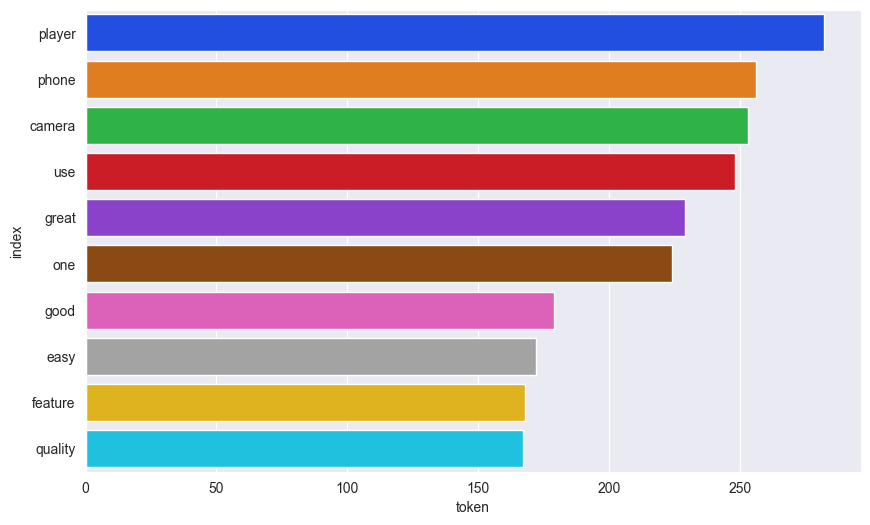

In [25]:
# Top 10 words without stopwords
plt.figure(figsize=(10, 6))
counts  = Xtrain['token'].value_counts(ascending=False).reset_index().head(10)
sns.barplot(data = counts, y = 'index', x = 'token', orient= 'h', palette= 'bright')
plt.show()

In [26]:
Xtrain[['clean_text','token']]

,clean_text,token
train_idx,,
0,i really do recommend this to anyone in need o...,really
0,i really do recommend this to anyone in need o...,recommend
0,i really do recommend this to anyone in need o...,anyone
0,i really do recommend this to anyone in need o...,need
0,i really do recommend this to anyone in need o...,new
...,...,...
3015,"the fm tuner , the 5g of storage , and the rem...",storage
3015,"the fm tuner , the 5g of storage , and the rem...",removable
3015,"the fm tuner , the 5g of storage , and the rem...",disk


In [27]:
listaTrain = []
listaTest = []
for i in range(train.shape[0]):
    listaTrain.append(' '.join(Xtrain.reset_index()[Xtrain.reset_index().train_idx == i]['token']))
for i in range(test.shape[0]):
    listaTest.append(' '.join(Xtest.reset_index()[Xtest.reset_index().test_idx == i]['token']))

XtrainNew = pd.DataFrame(listaTrain)
XtestNew = pd.DataFrame(listaTest)

In [28]:
XtrainNew.loc[[6,988,1767,2497,2714,2912],0]

6                                   say o phone run issue
988       o ab confusing st within day pas learning curve
1767       software mediasource work pc laptop intel xp o
2497    notice turn phone o take bit load initially me...
2714         every time nomad think file corrupt o freeze
2912    think o control well thought although admit bi...
Name: 0, dtype: object

In [29]:
os = []
for sentence in Xtrain.clean_text:
    if ' os ' in sentence:
        os.append((Xtrain[Xtrain.clean_text == sentence].index[0]))

In [30]:
set(os)

{6, 988, 1767, 2497, 2599, 2714, 2912}

In [31]:
XtrainNew.loc[[6,988,2497,2714,2912],0] = XtrainNew.loc[[6,988,2497,2714,2912],0].\
    apply(lambda x: x.replace(' o ', ' os ') )
XtrainNew.loc[[6,988,2497,2714,2912],0] = XtrainNew.loc[[6,988,2497,2714,2912],0].\
    apply(lambda x: x.replace('o ', 'os ') )
XtrainNew.loc[1767,0] = XtrainNew.loc[1767,0].replace(' o', ' os')

In [32]:
XtrainNew.loc[[6,988,1767,2497,2714,2912],0]

6                                  say os phone run issue
988      os ab confusing st within day pas learning curve
1767      software mediasource work pc laptop intel xp os
2497    notice turn phone os take bit load initially m...
2714        every time nomad think file corrupt os freeze
2912    think os control well thought although admit b...
Name: 0, dtype: object

In [33]:
os = []
for sentence in Xtest.clean_text:
    if ' os ' in sentence:
        os.append((Xtest[Xtest.clean_text == sentence].index[0]))

In [34]:
set(os)

{11, 91, 725}

In [35]:
XtestNew.loc[[11,91,725],0]

11     quite simply firmware o control thing ready pr...
91     simian series o great offer lot proprietary so...
725    nokia run symbian o work pretty well standard ...
Name: 0, dtype: object

In [36]:
XtestNew.loc[[11,91,725],0] = XtestNew.loc[[11,91,725],0].apply(lambda x: x.replace(' o ', ' os ') )

In [37]:
XtestNew.loc[[11,91,725],0]

11     quite simply firmware os control thing ready p...
91     simian series os great offer lot proprietary s...
725    nokia run symbian os work pretty well standard...
Name: 0, dtype: object

In [38]:
XtrainNew

,0
0,really recommend anyone need new player
1,good every day camera fit nicely pocket jean t...
2,dollar dollar dvd player probably best
3,got phone yesterday find problem yet
4,price gb storage
...,...
3007,multiple user one machine never seemed behave ...
3008,love storage thing
3009,wanted raised panel work needed power variable...
3010,big would probably another since shop complete...


In [39]:
XtrainNew.to_csv('../Data/New/xtrain.csv', sep = '|')
XtestNew.to_csv('../Data/New/xtest.csv', sep = '|')

In [40]:
tfidf_vectorizador = TfidfVectorizer(ngram_range=(1, 3), stop_words=None, min_df=0.005)
tfidf_vectorizador.fit(XtrainNew[0])

TfidfVectorizer(min_df=0.005, ngram_range=(1, 3))

In [41]:
Xtrain = tfidf_vectorizador.fit_transform(XtrainNew[0])
Xtest = tfidf_vectorizador.transform(XtestNew[0])
Ytrain = train.label

In [42]:
pd.DataFrame(Xtrain.toarray(), columns=tfidf_vectorizador.get_feature_names_out())

,ability,able,access,actually,adjustment,almost,already,also,although,always,...,working,worth,would,xtra,year,yet,zen,zen micro,zen xtra,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.554401,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.338875,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.293712,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [43]:
Xtrain = pd.DataFrame(Xtrain.toarray(), columns=tfidf_vectorizador.get_feature_names_out())
Xtest = pd.DataFrame(Xtest.toarray(), columns=tfidf_vectorizador.get_feature_names_out())

In [44]:
kf = KFold(n_splits=3, shuffle=True, random_state=0)

In [45]:
models = []
models.append(('glm', LogisticRegression(random_state=99)))
models.append(('dectree', DecisionTreeClassifier(random_state=99)))
models.append(('rf', RandomForestClassifier(random_state=99)))
models.append(('gb', GradientBoostingClassifier(random_state=99)))
models.append(('xgb', XGBClassifier()))
models.append(('bag', BaggingClassifier(random_state=99)))
models.append(('svmr', SVC(random_state=99)))
models.append(('svml', SVC(kernel='linear', random_state=99)))


def boxplots_algorithms(results, names):
    plt.figure(figsize=(8, 8))
    plt.boxplot(results)
    plt.xticks(range(1, len(names) + 1), names)
    plt.show()

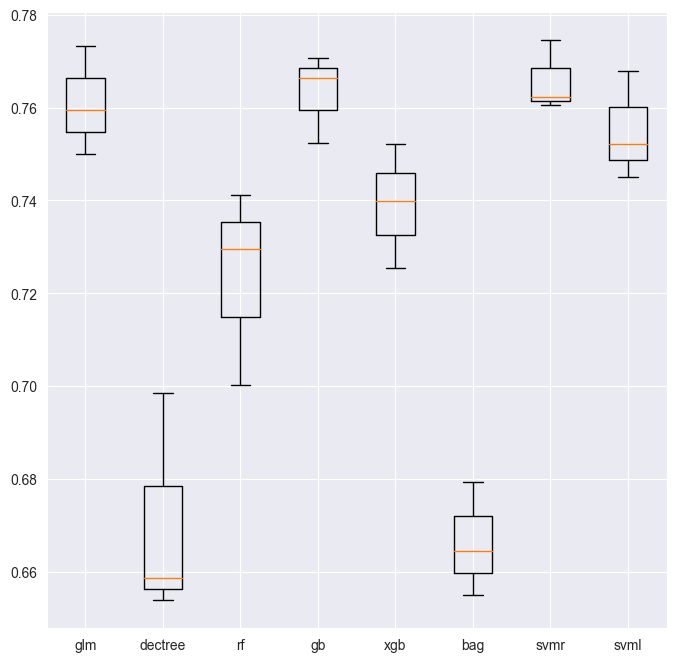

In [46]:
results = []
names = []

for name, model in models:
    acc = cross_val_score(model, Xtrain, Ytrain, cv=kf, scoring='f1')
    names.append(name)
    results.append(acc)

boxplots_algorithms(results, names)

In [47]:
glm = LogisticRegression(random_state=0)
glm.fit(Xtrain,Ytrain)

LogisticRegression(random_state=0)

In [49]:
df2 = pd.DataFrame(zip(pd.DataFrame(Xtrain, columns=tfidf_vectorizador.get_feature_names_out()),glm.coef_[0]))
df2.columns = ['feat','importance']
df2['abs'] = abs(df2.importance)
df2.sort_values('abs',ascending = False,inplace=True)

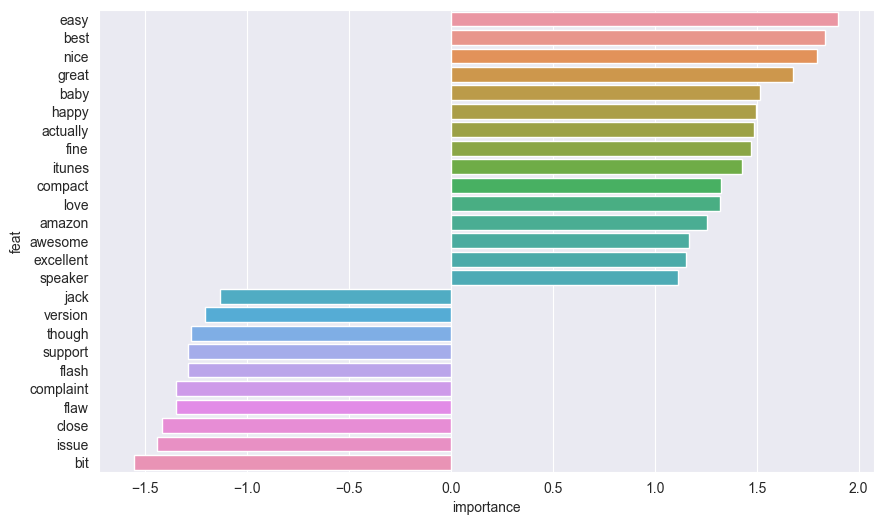

In [51]:
plt.figure(figsize=(10,6))
# cogemos sólo las más relevantes para que se vea el gráfico
sns.barplot(data = df2.iloc[:25,:].sort_values('importance',ascending = False)
            , y = 'feat', x = 'importance' , orient = 'h')
plt.show()

In [ ]:
Xtrain = pd.DataFrame(Xtrain.toarray(), columns=tfidf_vectorizador.get_feature_names_out())

xtrain,xtest,ytrain,ytest = train_test_split(Xtrain,Ytrain,test_size= 0.2)

xtrain = asarray(xtrain)
ytrain = asarray(ytrain)
xtest = asarray(xtest)
ytest = asarray(ytest)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
# definimos la red
model = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=[357]) # umbral por defecto de 0.5
])
# sigmoid nos dice que el problema va a ser de clasificación (1s o 0s)
# la métrica y el tipo de red
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    #metrics=['binary_accuracy']
    metrics=[f1_m],
)
# definimos el early stopping para evitar sobreajuste
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
)
# lo ajustamos y usamos el test para validar
# definimos un número de épocas alto, porque tenemos early stopping
history = model.fit(
    xtrain, ytrain,
    validation_data=(xtest, ytest),
    batch_size=256,
    epochs=700,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)
# guardamos los datos en un dataframe
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['f1_m', 'val_f1_m']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation f1: {:0.4f}")\
      .format(history_df['f1_m'].min(),
              history_df['val_f1_m'].max()))